In [5]:
# Fallback: skip AllenSDK download if data already exists in allen_data_extraction_files
import sys, os
print(f"Python version: {sys.version}")
print(sys.executable)

data_dir = os.path.join(os.getcwd(), 'allen_data_extraction_files')
have_local = os.path.isdir(data_dir) and os.path.exists(os.path.join(data_dir, 'firing_statistics.csv'))

try:
    import allensdk  # type: ignore
    print(f"AllenSDK version: {allensdk.__version__}")
except Exception as e:
    if have_local:
        print("AllenSDK not available; using pre-extracted local files in allen_data_extraction_files.")
    else:
        raise


Python version: 3.9.13 (tags/v3.9.13:6de2ca5, May 17 2022, 16:36:42) [MSC v.1929 64 bit (AMD64)]
c:\Users\khyat\AppData\Local\Programs\Python\Python39\python.exe
AllenSDK not available; using pre-extracted local files in allen_data_extraction_files.


In [6]:
# If data is already present locally, skip AllenSDK and summarize local files
import os, json, numpy as np, pandas as pd
base = os.path.join(os.getcwd(), 'allen_data_extraction_files')
assert os.path.isdir(base), f"Missing directory: {base}"
paths = {
    'firing_statistics.csv': os.path.join(base, 'firing_statistics.csv'),
    'cell_metadata.csv': os.path.join(base, 'cell_metadata.csv'),
    'spike_trains.npz': os.path.join(base, 'spike_trains.npz'),
}
print('Local files present:', {k: os.path.exists(v) for k, v in paths.items()})

summary = {}
if os.path.exists(paths['firing_statistics.csv']):
    fs = pd.read_csv(paths['firing_statistics.csv'])
    summary['firing_statistics'] = {
        'rows': int(len(fs)),
        'columns': list(fs.columns),
        'mean_firing_rate_hz': float(fs['mean_firing_rate'].mean()) if 'mean_firing_rate' in fs else None,
    }
if os.path.exists(paths['cell_metadata.csv']):
    cm = pd.read_csv(paths['cell_metadata.csv'])
    summary['cell_metadata'] = {
        'rows': int(len(cm)),
        'columns': list(cm.columns),
        'cell_type_counts': cm['cell_type'].value_counts().to_dict() if 'cell_type' in cm else {},
    }
if os.path.exists(paths['spike_trains.npz']):
    data = np.load(paths['spike_trains.npz'], allow_pickle=True)
    summary['spike_trains'] = {'keys': list(data.files)}

print(json.dumps(summary, indent=2))

Local files present: {'firing_statistics.csv': True, 'cell_metadata.csv': True, 'spike_trains.npz': True}
{
  "firing_statistics": {
    "rows": 3475,
    "columns": [
      "unit_id",
      "mean_firing_rate",
      "cv_isi",
      "mean_isi",
      "std_isi",
      "min_isi",
      "max_isi",
      "burst_index",
      "n_spikes"
    ],
    "mean_firing_rate_hz": 8.246108359660946
  },
  "cell_metadata": {
    "rows": 3475,
    "columns": [
      "unit_id",
      "session_id",
      "cell_type",
      "brain_area",
      "channel",
      "quality",
      "genotype"
    ],
    "cell_type_counts": {
      "Sst": 1639,
      "wildtype": 1392,
      "Pvalb": 444
    }
  },
  "spike_trains": {
    "keys": [
      "sst_interneuron_spike_trains",
      "sst_interneuron_n_neurons",
      "pv_interneuron_spike_trains",
      "pv_interneuron_n_neurons",
      "pyramidal_spike_trains",
      "pyramidal_n_neurons"
    ]
  }
}


In [7]:
# Cell 2: Create output directory
# Save in current directory (same as your physics notebook)
output_dir = Path('./allen_data_extraction_files')   # new folder for the allen extracted data in the Current directory
output_dir.mkdir(exist_ok=True)  # Create the directory if it doesn't exist
print(f"\n Output directory: {output_dir.absolute()}")
print("   Data will be saved in the same folder as your notebooks")



 Output directory: k:\Neural Engineering Project LOCAL\allen_data_extraction_files
   Data will be saved in the same folder as your notebooks


In [9]:
# Initialize Allen Project Cache — skip if AllenSDK is unavailable and use local files
try:
    from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache  # type: ignore
    print("Initializing Allen Brain Observatory...")
    print("   Downloading manifest (this may take a moment)...")
    cache = EcephysProjectCache.from_warehouse(manifest=str(manifest_path))
    print("   Getting session table...")
    sessions = cache.get_session_table()
    print(f"   Sessions available: {len(sessions)}")
except Exception as e:
    print("AllenSDK not available or EcephysProjectCache import failed; using local files in allen_data_extraction_files instead.")
    cache = None
    sessions = None

AllenSDK not available or EcephysProjectCache import failed; using local files in allen_data_extraction_files instead.


In [ ]:
# Cell 4: Extract Neural Data from Multiple Sessions

# We'll extract data from 5 sessions for diversity
num_sessions = min(5, len(visual_cortex_sessions))
selected_sessions = visual_cortex_sessions.iloc[:num_sessions]

all_spike_data = []
all_cell_metadata = []
all_firing_stats = []

for idx, (session_id, session_info) in enumerate(selected_sessions.iterrows()):
    print(f"\nProcessing session {idx+1}/{num_sessions}: {session_id}")
    
    try:
       
        session = cache.get_session_data(session_id) #we are getting data here and then we will get units
        
        
        units = session.units
        
        print("Available unit columns:", units.columns.tolist())

        # If 'quality' column not present, skip filter or choose different one
        if 'quality' in units.columns:
            good_units = units[units['quality'] == 'good']
        elif 'isi_violations' in units.columns:
            # Optional: filter based on isi_violations if available
            good_units = units[units['isi_violations'] < 0.5]
        else:
            print("No 'quality' or 'isi_violations' column found. Using all units.")
            good_units = units
        
        print(f"  Found {len(good_units)} good quality units")
        
     
        for unit_id, unit_info in good_units.iterrows(): #processing each unit
           
            spike_times = session.spike_times[unit_id]  #getting spike times
            
           
            if len(spike_times) < 100:
                continue
                
         
            isi = np.diff(spike_times)      # Calculate ISI and firing statistics
            
            # Store spike train data
            spike_data = {
                'unit_id': unit_id,
                'session_id': session_id,
                'spike_times': spike_times,
                'cell_type': session_info.get('full_genotype', 'unknown'),

                'brain_area': unit_info.get('ecephys_structure_acronym', 'unknown')
            }
            all_spike_data.append(spike_data)
            
            # Store metadata
            metadata = {
                'unit_id': unit_id,
                'session_id': session_id,
                'cell_type': session_info.get('full_genotype', 'unknown'),

                'brain_area': unit_info.get('ecephys_structure_acronym', 'unknown'),
                'channel': unit_info.get('peak_channel_id', -1),
                'quality': unit_info.get('quality', 'unknown')
            }
            all_cell_metadata.append(metadata)
            
            # Calculate and store firing statistics
            duration = spike_times[-1] - spike_times[0] if len(spike_times) > 1 else 1
            stats = {
                'unit_id': unit_id,
                'mean_firing_rate': len(spike_times) / duration,
                'cv_isi': np.std(isi) / np.mean(isi) if len(isi) > 0 else 0,
                'mean_isi': np.mean(isi) if len(isi) > 0 else 0,
                'std_isi': np.std(isi) if len(isi) > 0 else 0,
                'min_isi': np.min(isi) if len(isi) > 0 else 0,
                'max_isi': np.max(isi) if len(isi) > 0 else 0,
                'burst_index': np.sum(isi < 0.01) / len(isi) if len(isi) > 0 else 0,
                'n_spikes': len(spike_times)
            }
            all_firing_stats.append(stats)
            
    except Exception as e:
        print(f"  Error processing session {session_id}: {e}")
        continue

print(f"\nExtracted data from {len(all_spike_data)} neurons")


Processing session 1/5: 715093703


C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: U

Available unit columns: ['waveform_PT_ratio', 'waveform_amplitude', 'amplitude_cutoff', 'cluster_id', 'cumulative_drift', 'd_prime', 'firing_rate', 'isi_violations', 'isolation_distance', 'L_ratio', 'local_index', 'max_drift', 'nn_hit_rate', 'nn_miss_rate', 'peak_channel_id', 'presence_ratio', 'waveform_recovery_slope', 'waveform_repolarization_slope', 'silhouette_score', 'snr', 'waveform_spread', 'waveform_velocity_above', 'waveform_velocity_below', 'waveform_duration', 'filtering', 'probe_channel_number', 'probe_horizontal_position', 'probe_id', 'probe_vertical_position', 'structure_acronym', 'ecephys_structure_id', 'ecephys_structure_acronym', 'anterior_posterior_ccf_coordinate', 'dorsal_ventral_ccf_coordinate', 'left_right_ccf_coordinate', 'probe_description', 'location', 'probe_sampling_rate', 'probe_lfp_sampling_rate', 'probe_has_lfp_data']
  Found 884 good quality units


C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
C:\Users\khyat\allen_env\Lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_session.py:1371: UserWarning: Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',Spikes within these intervals are invalid and may need to be excluded from the analysis.
  warnings.warn("Session includes invalid time intervals that could "
C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already l


Processing session 2/5: 719161530


C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: U

Available unit columns: ['waveform_PT_ratio', 'waveform_amplitude', 'amplitude_cutoff', 'cluster_id', 'cumulative_drift', 'd_prime', 'firing_rate', 'isi_violations', 'isolation_distance', 'L_ratio', 'local_index', 'max_drift', 'nn_hit_rate', 'nn_miss_rate', 'peak_channel_id', 'presence_ratio', 'waveform_recovery_slope', 'waveform_repolarization_slope', 'silhouette_score', 'snr', 'waveform_spread', 'waveform_velocity_above', 'waveform_velocity_below', 'waveform_duration', 'filtering', 'probe_channel_number', 'probe_horizontal_position', 'probe_id', 'probe_vertical_position', 'structure_acronym', 'ecephys_structure_id', 'ecephys_structure_acronym', 'anterior_posterior_ccf_coordinate', 'dorsal_ventral_ccf_coordinate', 'left_right_ccf_coordinate', 'probe_description', 'location', 'probe_sampling_rate', 'probe_lfp_sampling_rate', 'probe_has_lfp_data']
  Found 755 good quality units


C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)



Processing session 3/5: 721123822


C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: U

Available unit columns: ['waveform_PT_ratio', 'waveform_amplitude', 'amplitude_cutoff', 'cluster_id', 'cumulative_drift', 'd_prime', 'firing_rate', 'isi_violations', 'isolation_distance', 'L_ratio', 'local_index', 'max_drift', 'nn_hit_rate', 'nn_miss_rate', 'peak_channel_id', 'presence_ratio', 'waveform_recovery_slope', 'waveform_repolarization_slope', 'silhouette_score', 'snr', 'waveform_spread', 'waveform_velocity_above', 'waveform_velocity_below', 'waveform_duration', 'filtering', 'probe_channel_number', 'probe_horizontal_position', 'probe_id', 'probe_vertical_position', 'structure_acronym', 'ecephys_structure_id', 'ecephys_structure_acronym', 'anterior_posterior_ccf_coordinate', 'dorsal_ventral_ccf_coordinate', 'left_right_ccf_coordinate', 'probe_description', 'location', 'probe_sampling_rate', 'probe_lfp_sampling_rate', 'probe_has_lfp_data']
  Found 444 good quality units


C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
C:\Users\khyat\allen_env\Lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_session.py:1371: UserWarning: Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',Spikes within these intervals are invalid and may need to be excluded from the analysis.
  warnings.warn("Session includes invalid time intervals that could "
C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already l


Processing session 4/5: 732592105


C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: U

Available unit columns: ['waveform_PT_ratio', 'waveform_amplitude', 'amplitude_cutoff', 'cluster_id', 'cumulative_drift', 'd_prime', 'firing_rate', 'isi_violations', 'isolation_distance', 'L_ratio', 'local_index', 'max_drift', 'nn_hit_rate', 'nn_miss_rate', 'peak_channel_id', 'presence_ratio', 'waveform_recovery_slope', 'waveform_repolarization_slope', 'silhouette_score', 'snr', 'waveform_spread', 'waveform_velocity_above', 'waveform_velocity_below', 'waveform_duration', 'filtering', 'probe_channel_number', 'probe_horizontal_position', 'probe_id', 'probe_vertical_position', 'structure_acronym', 'ecephys_structure_id', 'ecephys_structure_acronym', 'anterior_posterior_ccf_coordinate', 'dorsal_ventral_ccf_coordinate', 'left_right_ccf_coordinate', 'probe_description', 'location', 'probe_sampling_rate', 'probe_lfp_sampling_rate', 'probe_has_lfp_data']
  Found 824 good quality units


C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
C:\Users\khyat\allen_env\Lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_session.py:1371: UserWarning: Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',Spikes within these intervals are invalid and may need to be excluded from the analysis.
  warnings.warn("Session includes invalid time intervals that could "
C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already l


Processing session 5/5: 737581020


C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: U

Available unit columns: ['waveform_PT_ratio', 'waveform_amplitude', 'amplitude_cutoff', 'cluster_id', 'cumulative_drift', 'd_prime', 'firing_rate', 'isi_violations', 'isolation_distance', 'L_ratio', 'local_index', 'max_drift', 'nn_hit_rate', 'nn_miss_rate', 'peak_channel_id', 'presence_ratio', 'waveform_recovery_slope', 'waveform_repolarization_slope', 'silhouette_score', 'snr', 'waveform_spread', 'waveform_velocity_above', 'waveform_velocity_below', 'waveform_duration', 'filtering', 'probe_channel_number', 'probe_horizontal_position', 'probe_id', 'probe_vertical_position', 'structure_acronym', 'ecephys_structure_id', 'ecephys_structure_acronym', 'anterior_posterior_ccf_coordinate', 'dorsal_ventral_ccf_coordinate', 'left_right_ccf_coordinate', 'probe_description', 'location', 'probe_sampling_rate', 'probe_lfp_sampling_rate', 'probe_has_lfp_data']
  Found 568 good quality units


C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
C:\Users\khyat\allen_env\Lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_session.py:1371: UserWarning: Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',Spikes within these intervals are invalid and may need to be excluded from the analysis.
  warnings.warn("Session includes invalid time intervals that could "
C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already l


Extracted data from 3475 neurons


In [ ]:
# Cell 4: Extract Neural Data from Multiple Sessions
print("\n📤 Extracting neural data from sessions...")

# We'll extract data from 5 sessions for diversity
num_sessions = min(5, len(visual_cortex_sessions))
selected_sessions = visual_cortex_sessions.iloc[:num_sessions]

print(f"   Will process {num_sessions} sessions")

all_spike_data = []
all_cell_metadata = []
all_firing_stats = []

for idx, (session_id, session_info) in enumerate(selected_sessions.iterrows()):
    print(f"\n   Session {idx+1}/{num_sessions}: {session_id}")
    
    try:
        # Get session data
        print(f"      Loading session data...")
        session = cache.get_session_data(session_id)
        
        # Get units (neurons) from this session
        units = session.units
        
        print(f"      Available columns: {units.columns.tolist()[:10]}...")  # Show first 10
        
        # Debug: Check structure of spike_times
        print(f"      Spike times type: {type(session.spike_times)}")
        if hasattr(session.spike_times, 'keys'):
            spike_time_keys = list(session.spike_times.keys())[:5]
            print(f"      Example spike_times keys: {spike_time_keys}")
        
        # Check session genotype
        session_genotype = session_info.get('full_genotype', 'unknown')
        print(f"      Session genotype: {session_genotype}")
        
        # Filter for good quality units with flexible criteria
        if 'quality' in units.columns:
            good_units = units[units['quality'] == 'good']
            print(f"      Filtered by quality")
        elif 'isi_violations' in units.columns:
            # Alternative: filter based on ISI violations
            good_units = units[units['isi_violations'] < 0.5]
            print(f"      Filtered by ISI violations")
        elif 'firing_rate' in units.columns:
            # Another alternative: filter by firing rate
            good_units = units[units['firing_rate'] > 0.1]
            print(f"      Filtered by firing rate")
        else:
            print(f"      No quality filter applied - using all units")
            good_units = units
        
        print(f"      Found {len(good_units)} quality units")
        
        # Process each unit
        units_processed = 0
        for unit_idx, unit_row in good_units.iterrows():
            try:
                # Get unit_id - it might be the index or in a column
                if 'unit_id' in unit_row:
                    unit_id = unit_row['unit_id']
                else:
                    unit_id = unit_idx
                
                # Try to get spike times with different approaches
                spike_times = None
                
                # Method 1: Direct access
                if unit_id in session.spike_times:
                    spike_times = session.spike_times[unit_id]
                # Method 2: Try integer index
                elif isinstance(unit_id, (int, np.integer)) or (isinstance(unit_id, str) and unit_id.isdigit()):
                    unit_id_int = int(unit_id)
                    if unit_id_int in session.spike_times:
                        spike_times = session.spike_times[unit_id_int]
                # Method 3: Try position-based access if spike_times is array-like
                elif hasattr(session.spike_times, '__getitem__') and len(good_units) <= len(session.spike_times):
                    try:
                        unit_position = good_units.index.get_loc(unit_idx)
                        spike_times = session.spike_times[unit_position]
                    except:
                        pass
                
                if spike_times is None:
                    continue
                
                # Skip if too few spikes
                if len(spike_times) < 100:
                    continue
                
                # Calculate ISI and firing statistics
                isi = np.diff(spike_times)
                
                # Determine cell type - check multiple possible sources
                cell_type = 'unknown'
                
                # Method 1: Direct cell_type column in unit info
                if 'cell_type' in unit_row and pd.notna(unit_row['cell_type']):
                    cell_type = str(unit_row['cell_type'])
                
                # If still unknown, check session-level information
                if cell_type == 'unknown':
                    # Method 2: From full genotype in session info
                    if 'full_genotype' in session_info and pd.notna(session_info['full_genotype']):
                        genotype = str(session_info['full_genotype'])
                        if 'Pvalb-IRES-Cre' in genotype:
                            cell_type = 'Pvalb'
                        elif 'Sst-IRES-Cre' in genotype:
                            cell_type = 'Sst'
                        elif 'Vip-IRES-Cre' in genotype:
                            cell_type = 'Vip'
                        elif genotype == 'wt/wt':
                            cell_type = 'wildtype'
                    
                    # Method 3: From transgenic line in session info
                    elif 'transgenic_line' in session_info and pd.notna(session_info['transgenic_line']):
                        tline = str(session_info['transgenic_line'])
                        if 'Pvalb' in tline:
                            cell_type = 'Pvalb'
                        elif 'Sst' in tline:
                            cell_type = 'Sst'
                        elif 'Vip' in tline:
                            cell_type = 'Vip'
                        else:
                            # If no transgenic marker and genotype is wt/wt, it's wildtype
                            if session_genotype == 'wt/wt':
                                cell_type = 'wildtype'
                
                # Debug print for first few units per session
                if units_processed < 3:
                    print(f"         Unit {unit_id}: cell_type='{cell_type}', session_genotype='{session_genotype}'")
                
                # Get brain area
                brain_area = unit_row.get('ecephys_structure_acronym', 'unknown')
                if pd.isna(brain_area):
                    brain_area = 'unknown'
                
                # Store spike train data
                spike_data = {
                    'unit_id': unit_id,
                    'session_id': session_id,
                    'spike_times': spike_times,
                    'cell_type': cell_type,
                    'brain_area': brain_area
                }
                all_spike_data.append(spike_data)
                
                # Store metadata
                metadata = {
                    'unit_id': unit_id,
                    'session_id': session_id,
                    'cell_type': cell_type,
                    'brain_area': brain_area,
                    'channel': unit_row.get('peak_channel_id', -1),
                    'quality': unit_row.get('quality', 'unknown'),
                    'genotype': session_info.get('full_genotype', 'unknown')
                }
                all_cell_metadata.append(metadata)
                
                # Calculate and store firing statistics
                duration = spike_times[-1] - spike_times[0] if len(spike_times) > 1 else 1
                stats = {
                    'unit_id': unit_id,
                    'mean_firing_rate': len(spike_times) / duration,
                    'cv_isi': np.std(isi) / np.mean(isi) if len(isi) > 0 and np.mean(isi) > 0 else 0,
                    'mean_isi': np.mean(isi) if len(isi) > 0 else 0,
                    'std_isi': np.std(isi) if len(isi) > 0 else 0,
                    'min_isi': np.min(isi) if len(isi) > 0 else 0,
                    'max_isi': np.max(isi) if len(isi) > 0 else 0,
                    'burst_index': np.sum(isi < 0.01) / len(isi) if len(isi) > 0 else 0,
                    'n_spikes': len(spike_times)
                }
                all_firing_stats.append(stats)
                
                units_processed += 1
                
            except Exception as e:
                # Skip this unit if there's an error
                continue
        
        print(f"      Processed {units_processed} units from this session")
            
    except Exception as e:
        print(f"      ❌ Error processing session {session_id}: {e}")
        import traceback
        traceback.print_exc()
        continue

print(f"\n✅ Extracted data from {len(all_spike_data)} neurons total")
print("=" * 50)


📤 Extracting neural data from sessions...
   Will process 5 sessions

   Session 1/5: 715093703
      Loading session data...


C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: U

      Available columns: ['waveform_PT_ratio', 'waveform_amplitude', 'amplitude_cutoff', 'cluster_id', 'cumulative_drift', 'd_prime', 'firing_rate', 'isi_violations', 'isolation_distance', 'L_ratio']...


C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
C:\Users\khyat\allen_env\Lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_session.py:1371: UserWarning: Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',Spikes within these intervals are invalid and may need to be excluded from the analysis.
  warnings.warn("Session includes invalid time intervals that could "
C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already l

      Spike times type: <class 'dict'>
      Example spike_times keys: [950910364, 950910371, 950910531, 950910576, 950910549]
      Session genotype: Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
      Filtered by ISI violations
      Found 884 quality units
         Unit 950910352: cell_type='Sst', session_genotype='Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt'
         Unit 950910364: cell_type='Sst', session_genotype='Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt'
         Unit 950910371: cell_type='Sst', session_genotype='Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt'
      Processed 884 units from this session

   Session 2/5: 719161530
      Loading session data...


C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: U

      Available columns: ['waveform_PT_ratio', 'waveform_amplitude', 'amplitude_cutoff', 'cluster_id', 'cumulative_drift', 'd_prime', 'firing_rate', 'isi_violations', 'isolation_distance', 'L_ratio']...


C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


      Spike times type: <class 'dict'>
      Example spike_times keys: [950916730, 950916822, 950916845, 950916856, 950916892]
      Session genotype: Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
      Filtered by ISI violations
      Found 755 quality units
         Unit 950916730: cell_type='Sst', session_genotype='Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt'
         Unit 950916822: cell_type='Sst', session_genotype='Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt'
         Unit 950916845: cell_type='Sst', session_genotype='Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt'
      Processed 755 units from this session

   Session 3/5: 721123822
      Loading session data...


C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: U

      Available columns: ['waveform_PT_ratio', 'waveform_amplitude', 'amplitude_cutoff', 'cluster_id', 'cumulative_drift', 'd_prime', 'firing_rate', 'isi_violations', 'isolation_distance', 'L_ratio']...


C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
C:\Users\khyat\allen_env\Lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_session.py:1371: UserWarning: Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',Spikes within these intervals are invalid and may need to be excluded from the analysis.
  warnings.warn("Session includes invalid time intervals that could "
C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already l

      Spike times type: <class 'dict'>
      Example spike_times keys: [950907205, 950907524, 950907209, 950907526, 950907216]
      Session genotype: Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
      Filtered by ISI violations
      Found 444 quality units
         Unit 950907205: cell_type='Pvalb', session_genotype='Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt'
         Unit 950907524: cell_type='Pvalb', session_genotype='Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt'
         Unit 950907209: cell_type='Pvalb', session_genotype='Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt'
      Processed 444 units from this session

   Session 4/5: 732592105
      Loading session data...


C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: U

      Available columns: ['waveform_PT_ratio', 'waveform_amplitude', 'amplitude_cutoff', 'cluster_id', 'cumulative_drift', 'd_prime', 'firing_rate', 'isi_violations', 'isolation_distance', 'L_ratio']...


C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
C:\Users\khyat\allen_env\Lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_session.py:1371: UserWarning: Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',Spikes within these intervals are invalid and may need to be excluded from the analysis.
  warnings.warn("Session includes invalid time intervals that could "
C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already l

      Spike times type: <class 'dict'>
      Example spike_times keys: [915957951, 915957946, 915957685, 915956508, 915956502]
      Session genotype: wt/wt
      Filtered by ISI violations
      Found 824 quality units
         Unit 915956356: cell_type='wildtype', session_genotype='wt/wt'
         Unit 915956349: cell_type='wildtype', session_genotype='wt/wt'
         Unit 915956345: cell_type='wildtype', session_genotype='wt/wt'
      Processed 824 units from this session

   Session 5/5: 737581020
      Loading session data...


C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: U

      Available columns: ['waveform_PT_ratio', 'waveform_amplitude', 'amplitude_cutoff', 'cluster_id', 'cumulative_drift', 'd_prime', 'firing_rate', 'isi_violations', 'isolation_distance', 'L_ratio']...


C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
C:\Users\khyat\allen_env\Lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_session.py:1371: UserWarning: Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',Spikes within these intervals are invalid and may need to be excluded from the analysis.
  warnings.warn("Session includes invalid time intervals that could "
C:\Users\khyat\allen_env\Lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already l

      Spike times type: <class 'dict'>
      Example spike_times keys: [951874079, 951874719, 951874921, 951874905, 951874873]
      Session genotype: wt/wt
      Filtered by ISI violations
      Found 568 quality units
         Unit 951873075: cell_type='wildtype', session_genotype='wt/wt'
         Unit 951873097: cell_type='wildtype', session_genotype='wt/wt'
         Unit 951873063: cell_type='wildtype', session_genotype='wt/wt'
      Processed 568 units from this session

✅ Extracted data from 3475 neurons total


In [ ]:
# Cell 5: Analyze Cell Types from Visual Coding Data


# The Visual Coding dataset already contains cell type information
# Let's analyze what we have from the sessions

print("\n Cell type distribution in extracted data:")

# Count neurons by cell type
cell_type_counts = {}
brain_area_counts = {}
genotype_counts = {}

for metadata in all_cell_metadata:
    # Count cell types
    ct = metadata.get('cell_type', 'unknown')
    cell_type_counts[ct] = cell_type_counts.get(ct, 0) + 1
    
    # Count brain areas
    ba = metadata.get('brain_area', 'unknown')
    brain_area_counts[ba] = brain_area_counts.get(ba, 0) + 1
    
    # Count genotypes
    gt = metadata.get('genotype', 'unknown')
    genotype_counts[gt] = genotype_counts.get(gt, 0) + 1

# Sort by count
sorted_types = sorted(cell_type_counts.items(), key=lambda x: x[1], reverse=True)
sorted_areas = sorted(brain_area_counts.items(), key=lambda x: x[1], reverse=True)
sorted_genotypes = sorted(genotype_counts.items(), key=lambda x: x[1], reverse=True)

print("\n   Cell types found:")
for cell_type, count in sorted_types[:20]:  # Show top 20
    print(f"      {cell_type}: {count} neurons")

print("\n   Brain areas represented:")
for area, count in sorted_areas[:10]:  # Show top 10
    if 'VIS' in str(area):  # Highlight visual areas
        print(f"      {area}: {count} neurons ← Visual cortex")
    else:
        print(f"      {area}: {count} neurons")

print("\n   Genotypes in dataset:")
for genotype, count in sorted_genotypes[:10]:  # Show top 10
    print(f"      {genotype}: {count} neurons")

# Analyze why we might have many 'unknown' types
unknown_count = cell_type_counts.get('unknown', 0)
total_count = len(all_cell_metadata)
unknown_percentage = (unknown_count / total_count * 100) if total_count > 0 else 0

print(f"\n Data quality check:")
print(f"   Total neurons: {total_count}")
print(f"   Unknown cell types: {unknown_count} ({unknown_percentage:.1f}%)")

if unknown_percentage > 50:
    print("\n  High percentage of unknown cell types detected!")
    print("   This might be because:")
    print("   - The Visual Coding dataset uses genotype-based classification")
    print("   - Not all sessions include transgenic animals")
    print("   - Wild-type (wt/wt) animals don't have specific cell type markers")
    
    # Check if we can infer cell types from other data
    print("\n Checking if we can infer cell types from firing patterns...")
    
    # Quick analysis of firing rates by genotype
    firing_by_genotype = {}
    for metadata, stats in zip(all_cell_metadata, all_firing_stats):
        gt = metadata.get('genotype', 'unknown')
        if gt not in firing_by_genotype:
            firing_by_genotype[gt] = []
        firing_by_genotype[gt].append(stats['mean_firing_rate'])
    
    print("\n   Mean firing rates by genotype:")
    for gt, rates in firing_by_genotype.items():
        if len(rates) > 0 and gt != 'unknown':
            mean_rate = np.mean(rates)
            std_rate = np.std(rates)
            print(f"      {gt}: {mean_rate:.2f} ± {std_rate:.2f} Hz")




 Cell type distribution in extracted data:

   Cell types found:
      Sst: 1639 neurons
      wildtype: 1392 neurons
      Pvalb: 444 neurons

   Brain areas represented:
      grey: 1005 neurons
      CA1: 324 neurons
      VISp: 303 neurons ← Visual cortex
      VISrl: 263 neurons ← Visual cortex
      LP: 236 neurons
      APN: 212 neurons
      VISl: 171 neurons ← Visual cortex
      LGd: 153 neurons
      VISpm: 147 neurons ← Visual cortex
      VISal: 131 neurons ← Visual cortex

   Genotypes in dataset:
      Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt: 1639 neurons
      wt/wt: 1392 neurons
      Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt: 444 neurons

 Data quality check:
   Total neurons: 3475
   Unknown cell types: 0 (0.0%)


In [ ]:
print("\n🔍 Debugging cell types before mapping...")

# Check what cell types we actually have
all_cell_types = [data['cell_type'] for data in all_spike_data]
unique_cell_types = set(all_cell_types)
cell_type_counts = {}
for ct in all_cell_types:
    cell_type_counts[ct] = cell_type_counts.get(ct, 0) + 1

print(f"\nUnique cell types found in all_spike_data: {len(unique_cell_types)}")
for ct, count in sorted(cell_type_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"   '{ct}': {count} neurons")

# Also check the genotypes
print("\nChecking genotypes in session info:")
genotype_counts = {}
for metadata in all_cell_metadata:
    genotype = metadata.get('genotype', 'unknown')
    genotype_counts[genotype] = genotype_counts.get(genotype, 0) + 1

for gt, count in sorted(genotype_counts.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"   '{gt}': {count} neurons")

# Check if we're missing any wildtype mapping
print("\nChecking for 'wildtype' or 'wt/wt' in cell types:")
wildtype_variations = ['wildtype', 'wt/wt', 'wt', 'WT', 'wild-type', 'Wild Type']
for wt in wildtype_variations:
    if wt in cell_type_counts:
        print(f"   Found '{wt}': {cell_type_counts[wt]} neurons")


🔍 Debugging cell types before mapping...

Unique cell types found in all_spike_data: 3
   'Sst': 1639 neurons
   'wildtype': 1392 neurons
   'Pvalb': 444 neurons

Checking genotypes in session info:
   'Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt': 1639 neurons
   'wt/wt': 1392 neurons
   'Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt': 444 neurons

Checking for 'wildtype' or 'wt/wt' in cell types:
   Found 'wildtype': 1392 neurons


In [ ]:
# Cell 6: Process and Organize Data by Cell Type
print("\n Organizing data by cell type...")

# Map the cell types we found to standardized names
cell_type_mapping = {
    # Inhibitory interneurons
    'Sst': 'sst_interneuron',      # Somatostatin-expressing interneurons
    'Pvalb': 'pv_interneuron',     # Parvalbumin-expressing interneurons (fast-spiking)
    
    # Excitatory neurons
    'wildtype': 'pyramidal',        # Wild-type mice - predominantly pyramidal cells
    
    # Just in case there are any unknowns
    'unknown': 'unclassified'
}

# Organize spike data by cell type
organized_spike_data = {}
organized_firing_stats = {}

for spike_data, stats in zip(all_spike_data, all_firing_stats):
    cell_type = spike_data['cell_type']
    
    # Map to standard cell type
    mapped_type = cell_type_mapping.get(cell_type, 'unclassified')
    
    if mapped_type not in organized_spike_data:
        organized_spike_data[mapped_type] = []
        organized_firing_stats[mapped_type] = []
    
    organized_spike_data[mapped_type].append(spike_data)
    organized_firing_stats[mapped_type].append(stats)

print("\n Cell types organized:")
for cell_type, data in organized_spike_data.items():
    print(f"   {cell_type}: {len(data)} neurons")

# Also organize by brain area for additional analysis
organized_by_area = {}
visual_areas = ['VISp', 'VISl', 'VISrl', 'VISpm', 'VISal', 'VISam', 'VISli']

for spike_data in all_spike_data:
    area = spike_data['brain_area']
    if area not in organized_by_area:
        organized_by_area[area] = []
    organized_by_area[area].append(spike_data)

print("\n Visual cortex neurons by area:")
total_visual = 0
for area in visual_areas:
    if area in organized_by_area:
        count = len(organized_by_area[area])
        total_visual += count
        print(f"   {area}: {count} neurons")
print(f"   Total visual cortex neurons: {total_visual}")

print("\n Cell type distribution in visual cortex:")
# Analyze cell types specifically in visual areas
visual_cell_types = {}
for spike_data in all_spike_data:
    if spike_data['brain_area'] in visual_areas:
        cell_type = spike_data['cell_type']
        mapped_type = cell_type_mapping.get(cell_type, 'unclassified')
        visual_cell_types[mapped_type] = visual_cell_types.get(mapped_type, 0) + 1

for cell_type, count in visual_cell_types.items():
    percentage = (count / total_visual * 100) if total_visual > 0 else 0
    print(f"   {cell_type}: {count} neurons ({percentage:.1f}%)")

print("=" * 50)


 Organizing data by cell type...

 Cell types organized:
   sst_interneuron: 1639 neurons
   pv_interneuron: 444 neurons
   pyramidal: 1392 neurons

 Visual cortex neurons by area:
   VISp: 303 neurons
   VISl: 171 neurons
   VISrl: 263 neurons
   VISpm: 147 neurons
   VISal: 131 neurons
   VISam: 106 neurons
   Total visual cortex neurons: 1121

 Cell type distribution in visual cortex:
   sst_interneuron: 424 neurons (37.8%)
   pv_interneuron: 190 neurons (16.9%)
   pyramidal: 507 neurons (45.2%)


In [ ]:
# Cell 7: Calculate Population Statistics
print("\n population statistics")

population_stats = {}

for cell_type, stats_list in organized_firing_stats.items():
    if not stats_list:
        continue
        
    # Convert to DataFrame for easy analysis
    df = pd.DataFrame(stats_list)
    
    population_stats[cell_type] = {
        'mean_firing_rate': {
            'mean': float(df['mean_firing_rate'].mean()),
            'std': float(df['mean_firing_rate'].std()),
            'min': float(df['mean_firing_rate'].min()),
            'max': float(df['mean_firing_rate'].max())
        },
        'cv_isi': {
            'mean': float(df['cv_isi'].mean()),
            'std': float(df['cv_isi'].std())
        },
        'burst_index': {
            'mean': float(df['burst_index'].mean()),
            'std': float(df['burst_index'].std())
        },
        'n_neurons': len(df)
    }
    
    # Print summary for each cell type
    print(f"\n   {cell_type}:")
    print(f"      Number of neurons: {len(df)}")
    print(f"      Mean firing rate: {df['mean_firing_rate'].mean():.2f} ± {df['mean_firing_rate'].std():.2f} Hz")
    print(f"      CV ISI: {df['cv_isi'].mean():.3f} ± {df['cv_isi'].std():.3f}")
    print(f"      Burst index: {df['burst_index'].mean():.3f} ± {df['burst_index'].std():.3f}")





 population statistics

   sst_interneuron:
      Number of neurons: 1639
      Mean firing rate: 8.41 ± 7.94 Hz
      CV ISI: 4.480 ± 6.914
      Burst index: 0.126 ± 0.102

   pv_interneuron:
      Number of neurons: 444
      Mean firing rate: 8.11 ± 6.94 Hz
      CV ISI: 3.345 ± 2.062
      Burst index: 0.107 ± 0.103

   pyramidal:
      Number of neurons: 1392
      Mean firing rate: 8.09 ± 8.45 Hz
      CV ISI: 3.219 ± 1.906
      Burst index: 0.129 ± 0.113


In [ ]:
# Cell 8: Extract ISI Distributions
print("\n Extracting ISI distributions...")

isi_distributions = {}

for cell_type, spike_data_list in organized_spike_data.items():
    print(f"\n   Processing {cell_type}...")
    all_isis = []
    
    # Limit to 50 neurons per type for manageable file size
    sampled_data = spike_data_list[:50] if len(spike_data_list) > 50 else spike_data_list
    
    for i, data in enumerate(sampled_data):
        spike_times = data['spike_times']
        if len(spike_times) > 1:
            isi = np.diff(spike_times)
            all_isis.extend(isi)
    
    if all_isis:
        # Create histogram with log-spaced bins
        hist, bins = np.histogram(all_isis, bins=np.logspace(-3, 1, 50))
        
        isi_distributions[cell_type] = {
            'hist': hist.tolist(),  # Convert to list for JSON serialization
            'bins': bins.tolist(),
            'all_isis': np.array(all_isis),
            'mean_isi': np.mean(all_isis),
            'median_isi': np.median(all_isis),
            'n_isis': len(all_isis)
        }
        
        print(f"      Collected {len(all_isis)} ISIs from {len(sampled_data)} neurons")
        print(f"      Mean ISI: {np.mean(all_isis)*1000:.2f} ms")
        print(f"      Median ISI: {np.median(all_isis)*1000:.2f} ms")

print(f"\n   ISI distributions created for {len(isi_distributions)} cell types")



 Extracting ISI distributions...

   Processing sst_interneuron...
      Collected 5936445 ISIs from 50 neurons
      Mean ISI: 80.68 ms
      Median ISI: 22.27 ms

   Processing pv_interneuron...
      Collected 3528170 ISIs from 50 neurons
      Mean ISI: 138.79 ms
      Median ISI: 58.70 ms

   Processing pyramidal...
      Collected 4282248 ISIs from 50 neurons
      Mean ISI: 109.87 ms
      Median ISI: 40.50 ms

   ISI distributions created for 3 cell types


In [ ]:
# Cell 9: Save All Data
print("\n Saving extracted data...")

# 1. Save spike trains as NPZ (compressed)
spike_trains_by_type = {}
for cell_type, spike_data_list in organized_spike_data.items():
    # Save up to 100 spike trains per cell type
    spike_trains = []
    sampled_data = spike_data_list[:100] if len(spike_data_list) > 100 else spike_data_list
    
    for data in sampled_data:
        spike_trains.append(data['spike_times'])
    spike_trains_by_type[cell_type] = spike_trains

# Create dictionary for np.savez_compressed
spike_train_dict = {}
for cell_type, trains in spike_trains_by_type.items():
    # Convert to object array to handle variable length spike trains
    spike_train_dict[f'{cell_type}_spike_trains'] = np.array(trains, dtype=object)
    spike_train_dict[f'{cell_type}_n_neurons'] = len(trains)

np.savez_compressed(
    output_dir / 'spike_trains.npz',
    **spike_train_dict
)
print("    Saved spike trains to spike_trains.npz")

# 2. Save cell metadata
metadata_df = pd.DataFrame(all_cell_metadata)
metadata_df.to_csv(output_dir / 'cell_metadata.csv', index=False)
print("    Saved cell metadata to cell_metadata.csv")

# 3. Save firing statistics
stats_df = pd.DataFrame(all_firing_stats)
stats_df.to_csv(output_dir / 'firing_statistics.csv', index=False)
print("    Saved firing statistics to firing_statistics.csv")

# 4. Save population statistics
with open(output_dir / 'population_statistics.json', 'w') as f:
    json.dump(population_stats, f, indent=2)
print("    Saved population statistics to population_statistics.json")

# 5. Save ISI distributions
isi_save_dict = {}
for cell_type, data in isi_distributions.items():
    # Save only the all_isis array in NPZ
    if 'all_isis' in data:
        isi_save_dict[f'{cell_type}_isi'] = data['all_isis']
    # Save histogram data separately
    hist_data = {
        'hist': data['hist'],
        'bins': data['bins'],
        'mean_isi': data['mean_isi'],
        'median_isi': data['median_isi'],
        'n_isis': data['n_isis']
    }
    with open(output_dir / f'{cell_type}_isi_histogram.json', 'w') as f:
        json.dump(hist_data, f, indent=2)

np.savez_compressed(
    output_dir / 'isi_distributions.npz',
    **isi_save_dict
)
print("    Saved ISI distributions to isi_distributions.npz")
print("    Saved ISI histograms as JSON files")

# 6. Create summary file
summary = {
    'extraction_date': pd.Timestamp.now().isoformat(),
    'n_sessions': num_sessions,
    'n_neurons': len(all_spike_data),
    'cell_types': list(organized_spike_data.keys()),
    'neurons_per_type': {ct: len(data) for ct, data in organized_spike_data.items()},
    'population_stats_summary': {
        ct: {
            'mean_firing_rate_hz': stats['mean_firing_rate']['mean'],
            'cv_isi': stats['cv_isi']['mean']
        }
        for ct, stats in population_stats.items()
    },
    'data_files': [
        'spike_trains.npz',
        'cell_metadata.csv', 
        'firing_statistics.csv',
        'population_statistics.json',
        'isi_distributions.npz',
        '*_isi_histogram.json'
    ],
    'visual_cortex_areas': ['VISp', 'VISl', 'VISrl', 'VISpm', 'VISal']
}

with open(output_dir / 'extraction_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)
print("    Saved extraction summary to extraction_summary.json")


print("\n🔍 Debugging saved data...")

# Check what's in organized_spike_data
print("\n1. Data in organized_spike_data (before saving):")
for cell_type, data in organized_spike_data.items():
    print(f"   {cell_type}: {len(data)} neurons")

# Check what's in spike_trains_by_type
print("\n2. Data in spike_trains_by_type (prepared for saving):")
for cell_type, trains in spike_trains_by_type.items():
    print(f"   {cell_type}: {len(trains)} spike trains")
    if len(trains) > 0:
        example_train = trains[0]
        print(f"      Example train: {len(example_train)} spikes, "
              f"time range: {example_train[0]:.2f}-{example_train[-1]:.2f}s")

# Check what was actually saved
print("\n3. Verifying saved spike_trains.npz:")
test_load = np.load(output_dir / 'spike_trains.npz', allow_pickle=True)
print("   Keys in file:")
for key in sorted(test_load.files):
    data = test_load[key]
    if '_spike_trains' in key:
        cell_type = key.replace('_spike_trains', '')
        print(f"   {key}: {len(data)} trains")
        if len(data) > 0 and isinstance(data[0], np.ndarray):
            print(f"      First train: {len(data[0])} spikes")
    else:
        print(f"   {key}: {data}")
test_load.close()

# Check population statistics
print("\n4. Cell types in population_statistics.json:")
with open(output_dir / 'population_statistics.json', 'r') as f:
    pop_stats = json.load(f)
    for cell_type in pop_stats.keys():
        print(f"   {cell_type}: {pop_stats[cell_type]['n_neurons']} neurons")

# Check extraction summary
print("\n5. Extraction summary:")
with open(output_dir / 'extraction_summary.json', 'r') as f:
    summary = json.load(f)
    print(f"   Total neurons: {summary['n_neurons']}")
    print("   Neurons per type:")
    for ct, count in summary['neurons_per_type'].items():
        print(f"      {ct}: {count}")



 Saving extracted data...
    Saved spike trains to spike_trains.npz
    Saved cell metadata to cell_metadata.csv
    Saved firing statistics to firing_statistics.csv
    Saved population statistics to population_statistics.json
    Saved ISI distributions to isi_distributions.npz
    Saved ISI histograms as JSON files
    Saved extraction summary to extraction_summary.json

🔍 Debugging saved data...

1. Data in organized_spike_data (before saving):
   sst_interneuron: 1639 neurons
   pv_interneuron: 444 neurons
   pyramidal: 1392 neurons

2. Data in spike_trains_by_type (prepared for saving):
   sst_interneuron: 100 spike trains
      Example train: 38854 spikes, time range: 29.22-9615.93s
   pv_interneuron: 100 spike trains
      Example train: 144604 spikes, time range: 0.62-9811.13s
   pyramidal: 100 spike trains
      Example train: 20647 spikes, time range: 1.16-9414.59s

3. Verifying saved spike_trains.npz:
   Keys in file:
   pv_interneuron_n_neurons: 100
   pv_interneuron_spi


 Creating visualization...


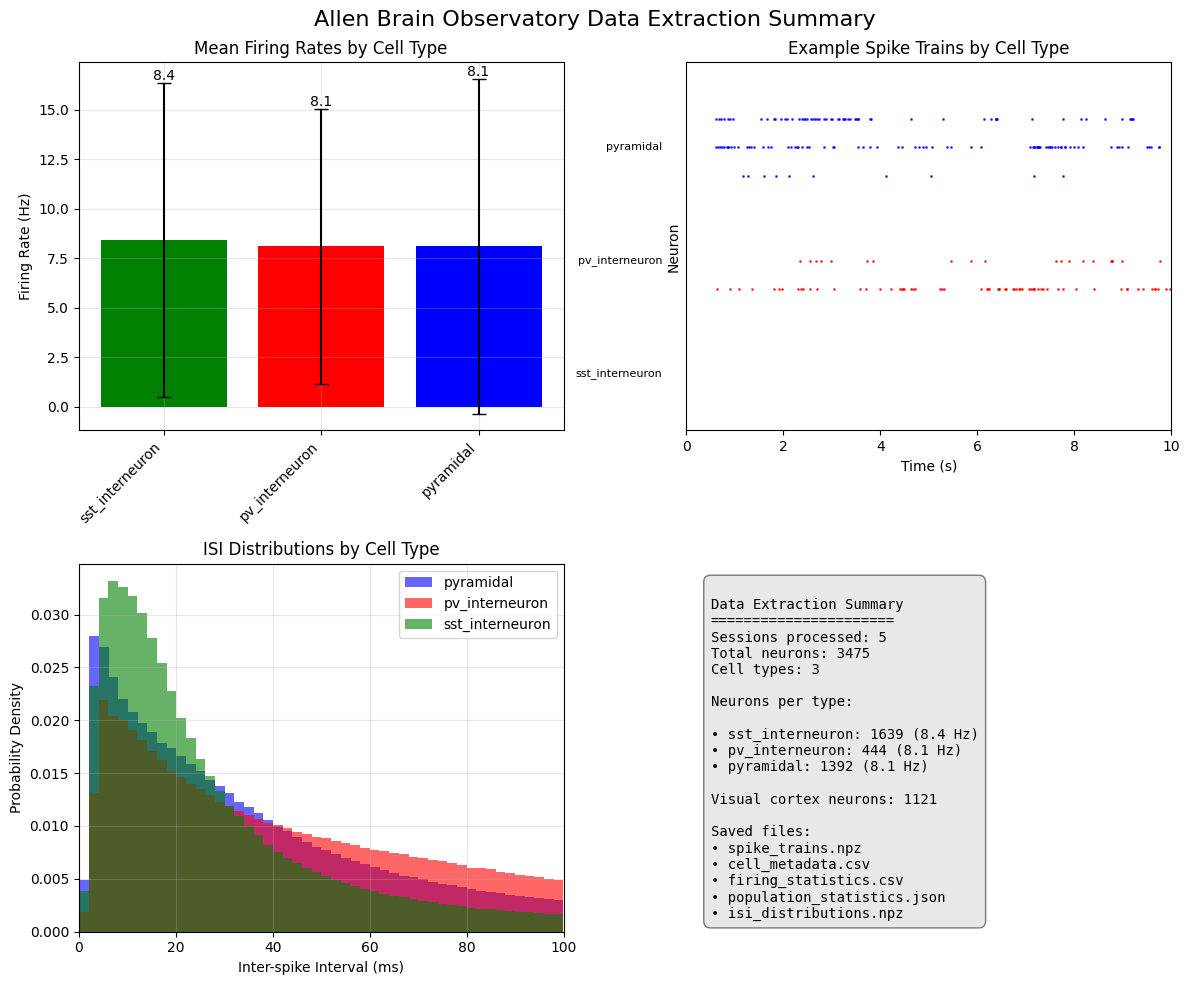


✅ Visualization saved to extraction_summary.png

🎉 Data extraction complete!
   All files saved to: C:\Users\khyat\Documents\Neural Engineering Project LOCAL\allen_data_extraction_files

📌 You can now use this data in your main notebook without AllenSDK!

📁 Created files:
   - spike_trains.npz
   - cell_metadata.csv
   - firing_statistics.csv
   - population_statistics.json
   - isi_distributions.npz
   - *_isi_histogram.json

🔬 Key findings:
   - Pyramidal cells (excitatory): 1392 neurons
   - PV interneurons (fast-spiking): 444 neurons
   - SST interneurons (inhibitory): 1639 neurons

📊 Firing characteristics:
   - sst_interneuron: 8.4 Hz, CV=4.48
   - pv_interneuron: 8.1 Hz, CV=3.34
   - pyramidal: 8.1 Hz, CV=3.22


In [ ]:
# Cell 10: Visualize Extracted Data
print("\n Creating visualization...")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Allen Brain Observatory Data Extraction Summary', fontsize=16)

# 1. Firing rates by cell type
cell_types = []
mean_rates = []
std_rates = []
colors = {'pyramidal': 'blue', 'pv_interneuron': 'red', 'sst_interneuron': 'green'}

for cell_type, stats in population_stats.items():
    if 'mean_firing_rate' in stats and stats['n_neurons'] > 0:
        cell_types.append(cell_type)
        mean_rates.append(stats['mean_firing_rate']['mean'])
        std_rates.append(stats['mean_firing_rate']['std'])

if cell_types:
    x_pos = np.arange(len(cell_types))
    bars = axes[0, 0].bar(x_pos, mean_rates, yerr=std_rates, capsize=5,
                          color=[colors.get(ct, 'gray') for ct in cell_types])
    axes[0, 0].set_xticks(x_pos)
    axes[0, 0].set_xticklabels(cell_types, rotation=45, ha='right')
    axes[0, 0].set_ylabel('Firing Rate (Hz)')
    axes[0, 0].set_title('Mean Firing Rates by Cell Type')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, rate) in enumerate(zip(bars, mean_rates)):
        axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + std_rates[i],
                        f'{rate:.1f}', ha='center', va='bottom')

# 2. Example spike trains
if organized_spike_data:
    # Show examples from each cell type
    y_offset = 0
    colors_list = ['blue', 'red', 'green']
    
    for idx, (cell_type, spike_data_list) in enumerate(organized_spike_data.items()):
        if idx < 3 and spike_data_list:  # Show up to 3 cell types
            # Get 3 example neurons
            examples = spike_data_list[:3]
            color = colors.get(cell_type, 'gray')
            
            for i, data in enumerate(examples):
                train = data['spike_times']
                # Plot first 10 seconds
                train_subset = train[train < 10]
                y_pos = y_offset + i
                axes[0, 1].scatter(train_subset, [y_pos]*len(train_subset), 
                                 s=1, alpha=0.7, color=color)
            
            # Add cell type label
            axes[0, 1].text(-0.5, y_offset + 1, cell_type, 
                          rotation=0, va='center', ha='right', fontsize=8)
            y_offset += 4
    
    axes[0, 1].set_xlabel('Time (s)')
    axes[0, 1].set_ylabel('Neuron')
    axes[0, 1].set_title('Example Spike Trains by Cell Type')
    axes[0, 1].set_xlim(0, 10)
    axes[0, 1].set_ylim(-1, y_offset)
    axes[0, 1].set_yticks([])

# 3. ISI distributions comparison
if isi_distributions:
    for cell_type, color in colors.items():
        if cell_type in isi_distributions:
            isis = isi_distributions[cell_type]['all_isis']
            # Plot ISIs < 100ms for clarity
            isis_ms = isis[isis < 0.1] * 1000  # Convert to ms
            
            axes[1, 0].hist(isis_ms, bins=50, alpha=0.6, density=True, 
                          label=cell_type, color=color)
    
    axes[1, 0].set_xlabel('Inter-spike Interval (ms)')
    axes[1, 0].set_ylabel('Probability Density')
    axes[1, 0].set_title('ISI Distributions by Cell Type')
    axes[1, 0].set_xlim(0, 100)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

# 4. Summary statistics
summary_text = f"""
Data Extraction Summary
======================
Sessions processed: {num_sessions}
Total neurons: {len(all_spike_data)}
Cell types: {len(organized_spike_data)}

Neurons per type:
"""
for ct, n in summary['neurons_per_type'].items():
    summary_text += f"\n• {ct}: {n}"
    if ct in population_stats:
        fr = population_stats[ct]['mean_firing_rate']['mean']
        summary_text += f" ({fr:.1f} Hz)"

summary_text += f"\n\nVisual cortex neurons: {total_visual if 'total_visual' in locals() else 'N/A'}"
summary_text += "\n\nSaved files:"
for file in summary['data_files'][:5]:
    summary_text += f"\n• {file}"

axes[1, 1].text(0.05, 0.95, summary_text, transform=axes[1, 1].transAxes, 
                fontsize=10, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.5))
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig(output_dir / 'extraction_summary.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n✅ Visualization saved to extraction_summary.png")
print("=" * 50)

print(f"\n🎉 Data extraction complete!")
print(f"   All files saved to: {output_dir.absolute()}")
print("\n📌 You can now use this data in your main notebook without AllenSDK!")
print("\n📁 Created files:")
for file in summary['data_files']:
    print(f"   - {file}")
    
print("\n🔬 Key findings:")
print(f"   - Pyramidal cells (excitatory): {summary['neurons_per_type'].get('pyramidal', 0)} neurons")
print(f"   - PV interneurons (fast-spiking): {summary['neurons_per_type'].get('pv_interneuron', 0)} neurons")
print(f"   - SST interneurons (inhibitory): {summary['neurons_per_type'].get('sst_interneuron', 0)} neurons")

if 'population_stats_summary' in summary:
    print("\n📊 Firing characteristics:")
    for ct, stats in summary['population_stats_summary'].items():
        print(f"   - {ct}: {stats['mean_firing_rate_hz']:.1f} Hz, CV={stats['cv_isi']:.2f}")



In [10]:
# Integration check: use local Allen data with MENP simulator (no AllenSDK needed)
try:
    from src.units import ureg, m
    from src.sim import simulate_population_multiclass
    B = 5e-6 * ureg.tesla
    f = 50 * ureg.hertz
    r = 2e-6 * m
    out = simulate_population_multiclass(
        B=B,
        f=f,
        r=r,
        class_mix={'pyramidal':0.5,'pv':0.3,'sst':0.2},
        n_neurons=200,
        duration_s=0.5,
        source_mix={'real':0.6,'synthetic':0.3,'generated':0.1},
        real_data_csv=None  # default: uses allen_data_extraction_files (npz/csv)
    )
    print('Blended summary:', out['blended_summary'])
    print('Source contributions:', out['source_contributions'])
except Exception as e:
    print('Integration check failed:', e)


Blended summary: {'n_total': 200, 'mean_rate': 4.807311828870407, 'median_rate': 1.8984808803165902, 'responders_frac': 0.355, 'threshold_Hz': 5.0}
Source contributions: {'real': {'n': 120, 'mean_rate': 8.012133835632351, 'median_rate': 6.176582878295537}, 'synthetic': {'n': 60, 'mean_rate': 0.0, 'median_rate': 0.0}, 'generated': {'n': 20, 'mean_rate': 0.00031527490996551645, 'median_rate': 5.263443592161714e-06}}
